# Linear Regression on properties dataset of Zillow

## Data Preprocessing and Exploratory Data Analysis(EDA)

### First we have imported various libraries so that we can use it for preprocessing the data

In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina' 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import enet_path, ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import math
from collections import Counter
import random
from scipy.stats import multivariate_normal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from tqdm import tqdm

# Read the data

In [132]:
train = pd.read_csv("train.data.csv", low_memory = False, index_col = 0)
test = pd.read_csv("test.data.csv", low_memory = False, index_col = 0)

In [133]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
4,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
5,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
6,7237550310,20140512T000000,1225000,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
7,1321400060,20140627T000000,257500,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


In [134]:
train.shape

(15129, 21)

In [135]:
train.dropna(inplace = True)
test.dropna(inplace = True)

In [137]:
train.shape

(15129, 21)

In [138]:
ohe = OneHotEncoder()
categories_train = ohe.fit_transform(train.loc[:, ['zipcode']]).toarray()

In [146]:
ohe.categories_[0]

array([98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
       98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029,
       98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042,
       98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070,
       98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106,
       98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119,
       98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155,
       98166, 98168, 98177, 98178, 98188, 98198, 98199])

In [141]:
categories_test = ohe.transform(test.loc[:, ['zipcode']]).toarray()

In [142]:
for i, cat in enumerate(ohe.categories_[0]):
    train[str(cat)] = categories_train[:, i]
    test[str(cat)] = categories_test[:, i]

In [143]:
train.drop(['zipcode'], axis = 1, inplace = True)
test.drop(['zipcode'], axis = 1, inplace = True)

In [148]:
train.columns.unique()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', '98001', '98002', '98003',
       '98004', '98005', '98006', '98007', '98008', '98010', '98011', '98014',
       '98019', '98022', '98023', '98024', '98027', '98028', '98029', '98030',
       '98031', '98032', '98033', '98034', '98038', '98039', '98040', '98042',
       '98045', '98052', '98053', '98055', '98056', '98058', '98059', '98065',
       '98070', '98072', '98074', '98075', '98077', '98092', '98102', '98103',
       '98105', '98106', '98107', '98108', '98109', '98112', '98115', '98116',
       '98117', '98118', '98119', '98122', '98125', '98126', '98133', '98136',
       '98144', '98146', '98148', '98155', '98166', '98168', '98177', '98178',
       '98188', '98198', '98199'],
      dtype='object')

In [145]:
test.shape

(6484, 90)

### Displaying the null values in the dataset. These null values need to filled with some appropriate value or should be dropped if they are irrelevant. This is an important step as a part of carrying out futher analysis and make the data completely ready for analysis.

In [87]:
train.isnull().sum().sort_values()

id       0
98106    0
98105    0
98103    0
98102    0
        ..
98007    0
98006    0
98005    0
98003    0
98199    0
Length: 90, dtype: int64

### Step Below drops the columns with maximum null values from the dataset, as these values are not important (since they have many NaN values) and will impact the overall prediction of future house prices.

### describe() function gives us the mean and minimum, count,also provides us with the mean and std values and also various set of values ranging from 25%,50% and 75%

In [88]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
count,1.512900e+04,1.512900e+04,15129.000000,15129.000000,15129.000000,1.512900e+04,15129.000000,15129.000000,15129.000000,15129.000000,...,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000
mean,4.561012e+09,5.381469e+05,3.365854,2.107327,2069.595743,1.469552e+04,1.490878,0.007403,0.234649,3.409545,...,0.012625,0.002776,0.020953,0.011369,0.012757,0.011435,0.011898,0.006081,0.013087,0.015467
std,2.868152e+09,3.674490e+05,0.938624,0.772123,918.759850,3.887165e+04,0.539352,0.085724,0.769640,0.651771,...,0.111652,0.052618,0.143232,0.106021,0.112228,0.106325,0.108429,0.077746,0.113653,0.123405
min,1.000102e+06,8.100000e+04,0.000000,0.000000,290.000000,6.000000e+02,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.121000e+09,3.220000e+05,3.000000,1.500000,1420.000000,5.030000e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.885808e+09,4.500000e+05,3.000000,2.250000,1900.000000,7.577000e+03,1.500000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.299500e+09,6.400000e+05,4.000000,2.500000,2540.000000,1.060900e+04,2.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### corr() function from pandas library of python or heatmap() function from seaborn library of python help us to identify the columns with maximum correlation and also allows us to decide and think logically which are the features that can be used based on the correlation.

In [89]:
train.iloc[:, :20].corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.017841,-0.001315,0.004364,-0.011424,-0.131088,0.014253,-0.004808,0.010086,-0.022949,0.006270,-0.011353,-0.002518,0.021467,-0.011921,-0.005651,0.019813,-0.007080,-0.132943
price,-0.017841,1.000000,0.304145,0.524313,0.702720,0.095473,0.255986,0.279261,0.414305,0.032684,0.664980,0.608705,0.322633,0.060840,0.113818,0.305911,0.028478,0.589884,0.091536
bedrooms,-0.001315,0.304145,1.000000,0.507918,0.572322,0.033167,0.168242,-0.008195,0.079537,0.034055,0.354767,0.469413,0.312069,0.147012,0.015946,-0.006984,0.127283,0.385935,0.036459
bathrooms,0.004364,0.524313,0.507918,1.000000,0.754786,0.092005,0.499891,0.067890,0.194189,-0.125113,0.665522,0.684271,0.289510,0.510628,0.039977,0.025576,0.233359,0.568139,0.095878
sqft_living,-0.011424,0.702720,0.572322,0.754786,1.000000,0.183029,0.353967,0.111716,0.295813,-0.058978,0.765403,0.877205,0.438544,0.319967,0.050855,0.056285,0.249867,0.759427,0.193847
sqft_lot,-0.131088,0.095473,0.033167,0.092005,0.183029,1.000000,-0.007588,0.026636,0.091493,-0.009795,0.117545,0.194631,0.016480,0.055191,0.003192,-0.083562,0.236359,0.156522,0.720683
floors,0.014253,0.255986,0.168242,0.499891,0.353967,-0.007588,1.000000,0.021476,0.030954,-0.269647,0.458907,0.521716,-0.240132,0.491403,0.008248,0.051674,0.128427,0.280088,-0.008020
waterfront,-0.004808,0.279261,-0.008195,0.067890,0.111716,0.026636,0.021476,1.000000,0.399479,0.010803,0.086797,0.073276,0.095267,-0.019979,0.084751,-0.013618,-0.032050,0.093886,0.030767
view,0.010086,0.414305,0.079537,0.194189,0.295813,0.091493,0.030954,0.399479,1.000000,0.040207,0.256504,0.175514,0.286917,-0.049641,0.100460,0.011946,-0.074738,0.291483,0.085665
condition,-0.022949,0.032684,0.034055,-0.125113,-0.058978,-0.009795,-0.269647,0.010803,0.040207,1.000000,-0.147935,-0.157463,0.172042,-0.357334,-0.060925,-0.019795,-0.105677,-0.090680,-0.000831


# Heatmaps: efficient way to look into correlations

<AxesSubplot:>

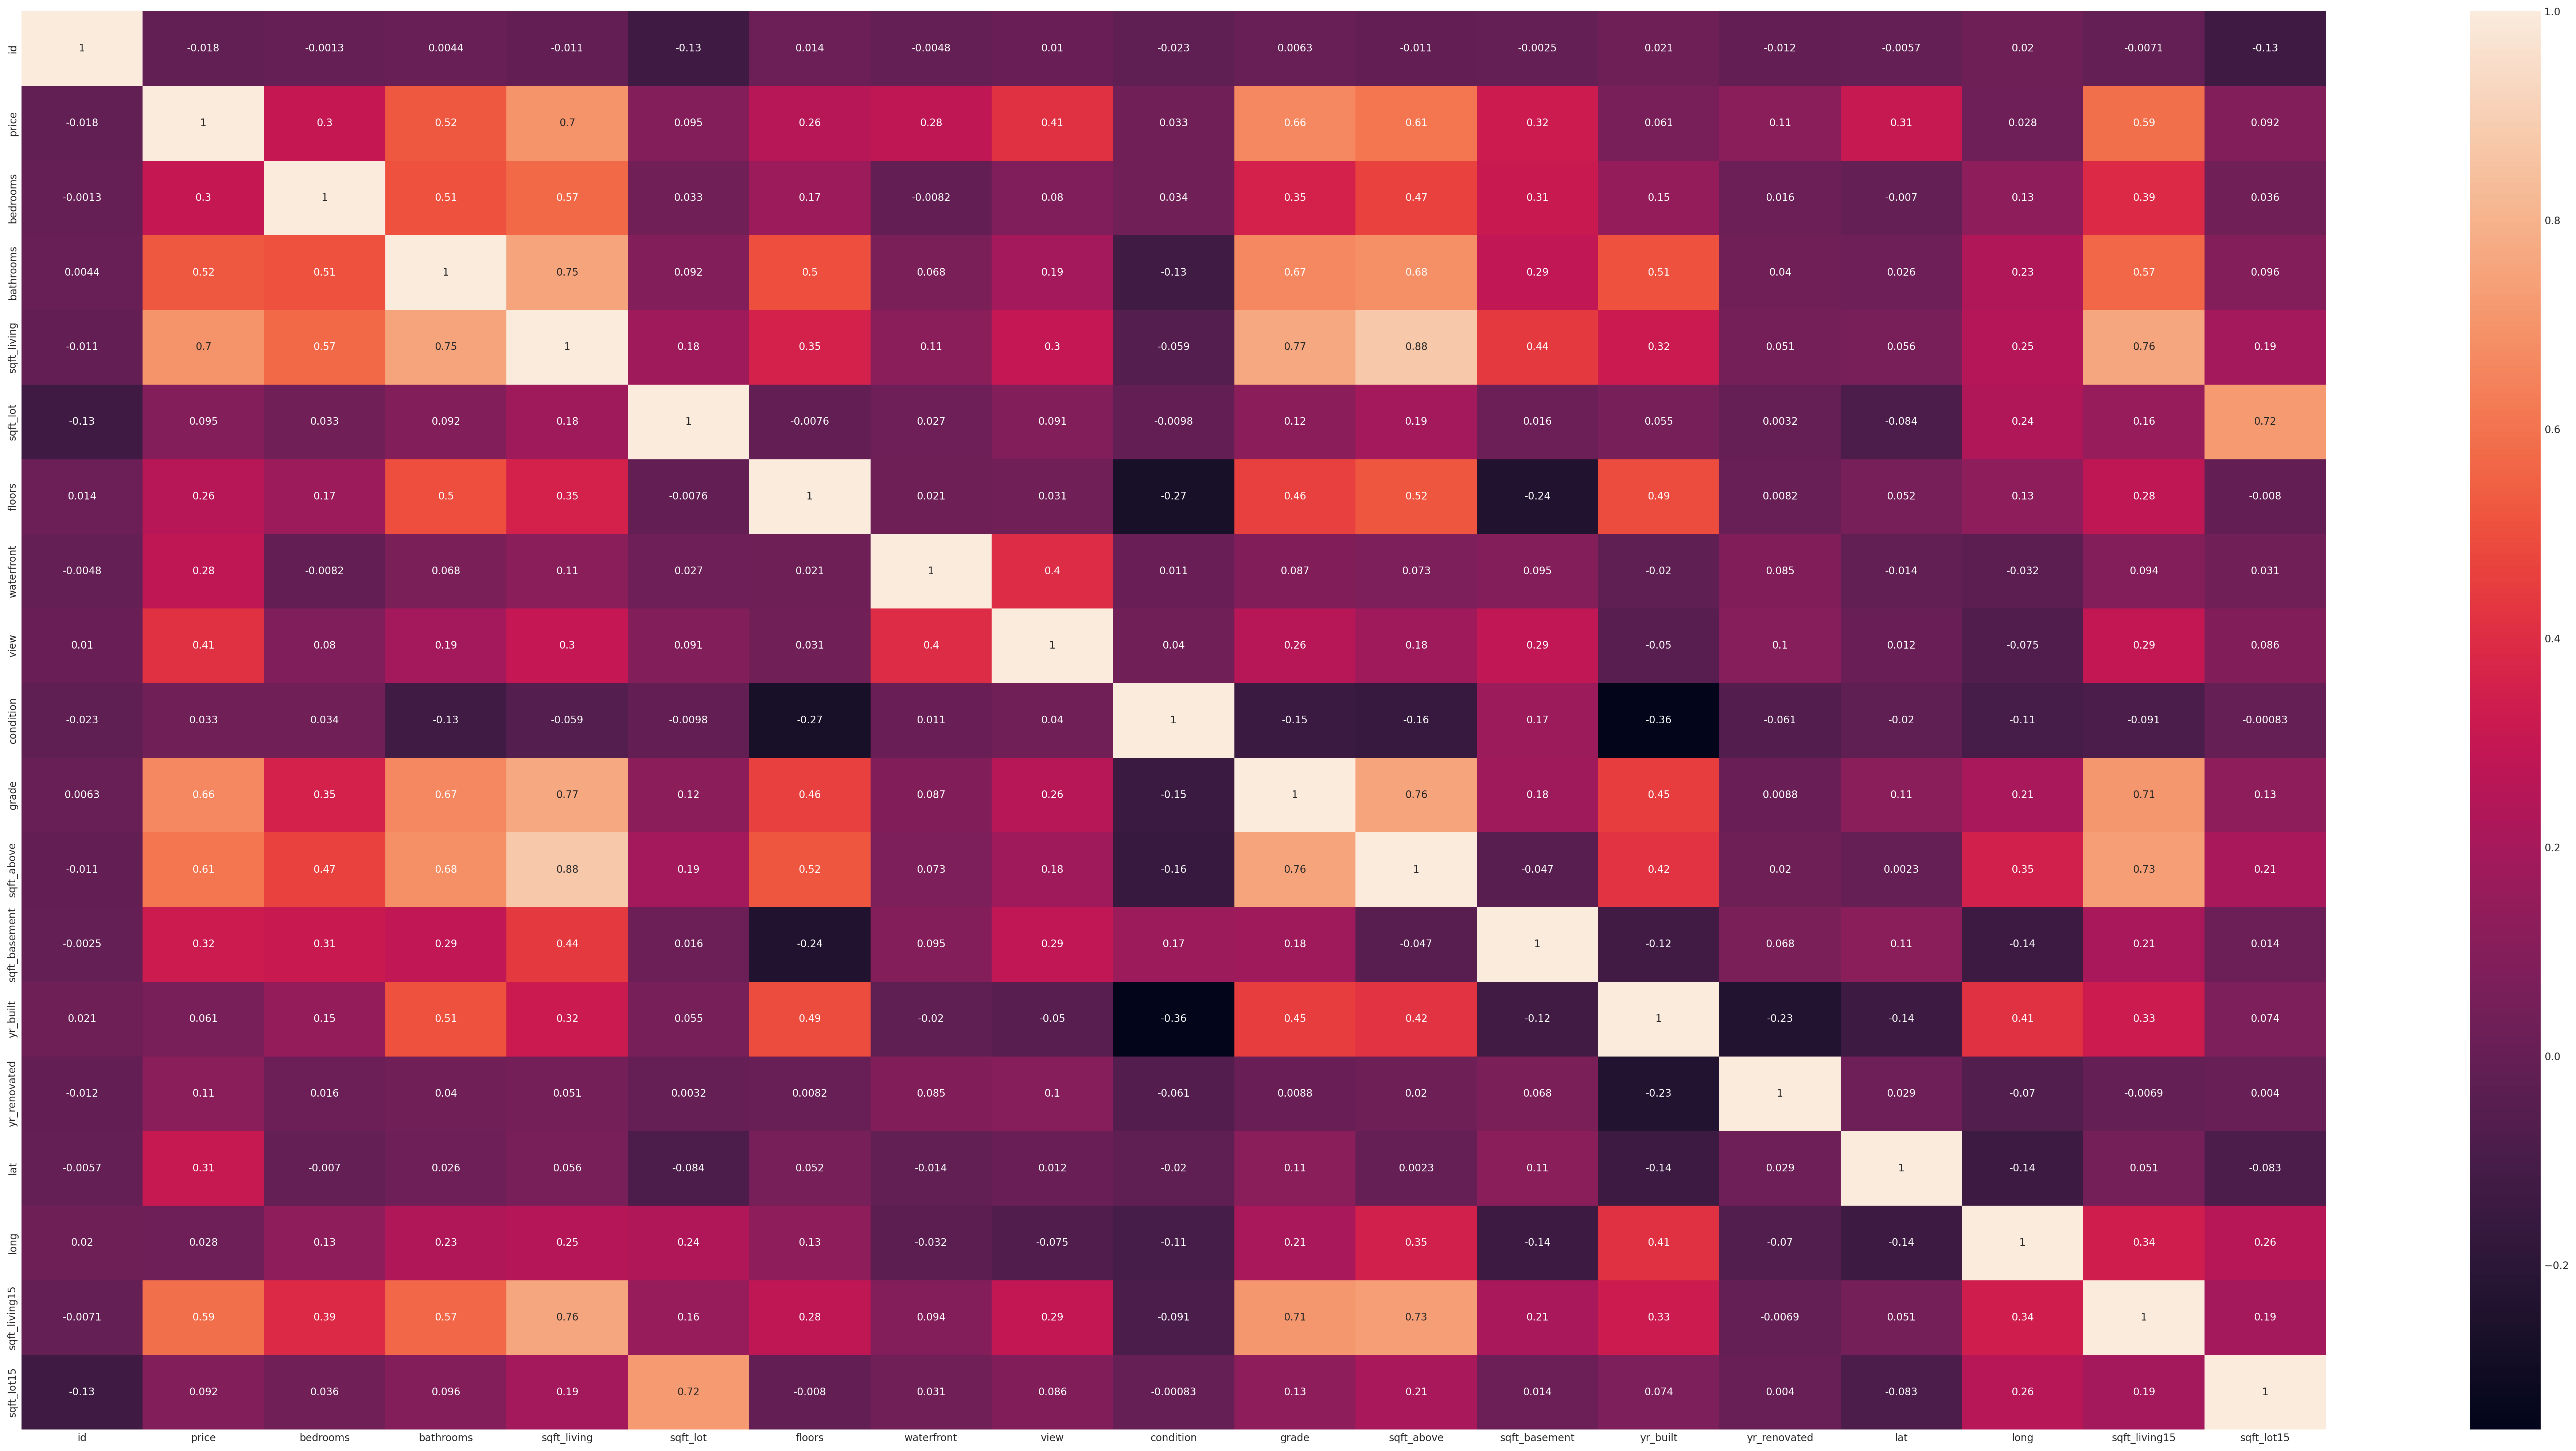

In [90]:
plt.figure(figsize=(40,20))
sns.heatmap(train.iloc[:, :20].corr(),annot=True)

## Linear Regression

In [91]:
train.drop(['id', 'date'], axis = 1, inplace = True)
test.drop(['id', 'date'], axis = 1, inplace = True)

In [92]:
X_train, y_train = train.drop(['price'], axis=1), train['price']
X_test, y_test = test.drop(['price'], axis=1), test['price']

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=200)

In [94]:
X_train.iloc[:, :18].head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,98001
2867,3,2.25,1630,10500,1.0,0,0,3,7,1100,530,1974,0,47.7176,-122.236,1640,9794,0.0
16875,4,2.50,2280,9827,2.0,0,0,3,8,2280,0,1995,0,47.6883,-122.168,1660,9827,0.0
3202,2,1.00,1790,4000,1.0,0,0,4,7,1040,750,1923,0,47.6405,-122.301,1310,4000,0.0
19207,4,2.75,2890,6825,1.0,0,0,3,8,1560,1330,1973,0,47.7340,-122.182,1900,10120,0.0
13020,3,1.00,1010,6300,1.0,0,0,3,7,1010,0,1957,0,47.7304,-122.352,1480,7480,0.0


In [95]:
for i, c in enumerate(X_train.columns):
    if i<18 and c!='view' and c!='waterfront':
        mu, sigma = np.mean(X_train.loc[:, c]), np.std(X_train.loc[:, c])
        X_train.loc[:, c] = (X_train.loc[:, c]-mu)/sigma
        X_val.loc[:, c] = (X_val.loc[:, c]-mu)/sigma
        X_test.loc[:, c] = (X_test.loc[:, c]-mu)/sigma
mu_y_train = np.mean(y_train)
sigma_y_train = np.std(y_train)
y_train = (y_train - mu_y_train)/sigma_y_train

In [96]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
2867,-0.378446,0.195006,-0.472042,-0.115888,-0.914479,0,0,-0.630641,-0.555241,-0.820235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16875,0.674313,0.521767,0.239355,-0.134220,0.923591,0,0,-0.630641,0.297971,0.607077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3202,-1.431204,-1.438800,-0.296929,-0.292945,-0.914479,0,0,0.901156,-0.555241,-0.892810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19207,0.674313,0.848528,0.906975,-0.215994,-0.914479,0,0,-0.630641,0.297971,-0.263825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13020,-0.378446,-1.438800,-1.150606,-0.230294,-0.914479,0,0,-0.630641,-0.555241,-0.929098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
X_train.shape

(9077, 87)

In [98]:
X_val.shape

(6052, 87)

In [99]:
lr = LinearRegression()

### We are here fitting the model into X_train and y_train

In [100]:
lr.fit(X_train,y_train)

LinearRegression()

In [101]:
lr.coef_

array([-5.85877806e-02,  4.90515441e-02,  8.48430309e+11,  1.59270854e-02,
       -7.19331660e-02,  2.05534562e+00,  1.61195534e-01,  4.75649009e-02,
        1.66726523e-01, -7.67676630e+11, -4.05618300e+11, -5.86076936e-02,
        1.33339845e-02,  8.06301619e-02, -5.84845474e-02, -9.42228499e-03,
       -3.58344534e-03,  6.83735886e+09,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  5.54843896e+10,  5.54843896e+10,  5.54843896e+10,
        5.54843896e+10,  

In [102]:
pd.DataFrame(lr.coef_,X_train.columns,columns=['Coeff'])

,Coeff
bedrooms,-5.858778e-02
bathrooms,4.905154e-02
sqft_living,8.484303e+11
sqft_lot,1.592709e-02
floors,-7.193317e-02
...,...
98177,5.548439e+10
98178,5.548439e+10
98188,5.548439e+10
98198,5.548439e+10


In [103]:
predictions = lr.predict(X_test)*sigma_y_train + mu_y_train

In [104]:
predictions

array([166452.89280661, 143020.34388053, 822988.08524113, ...,
       401896.24947796, 543396.07696968, 887596.83934492])

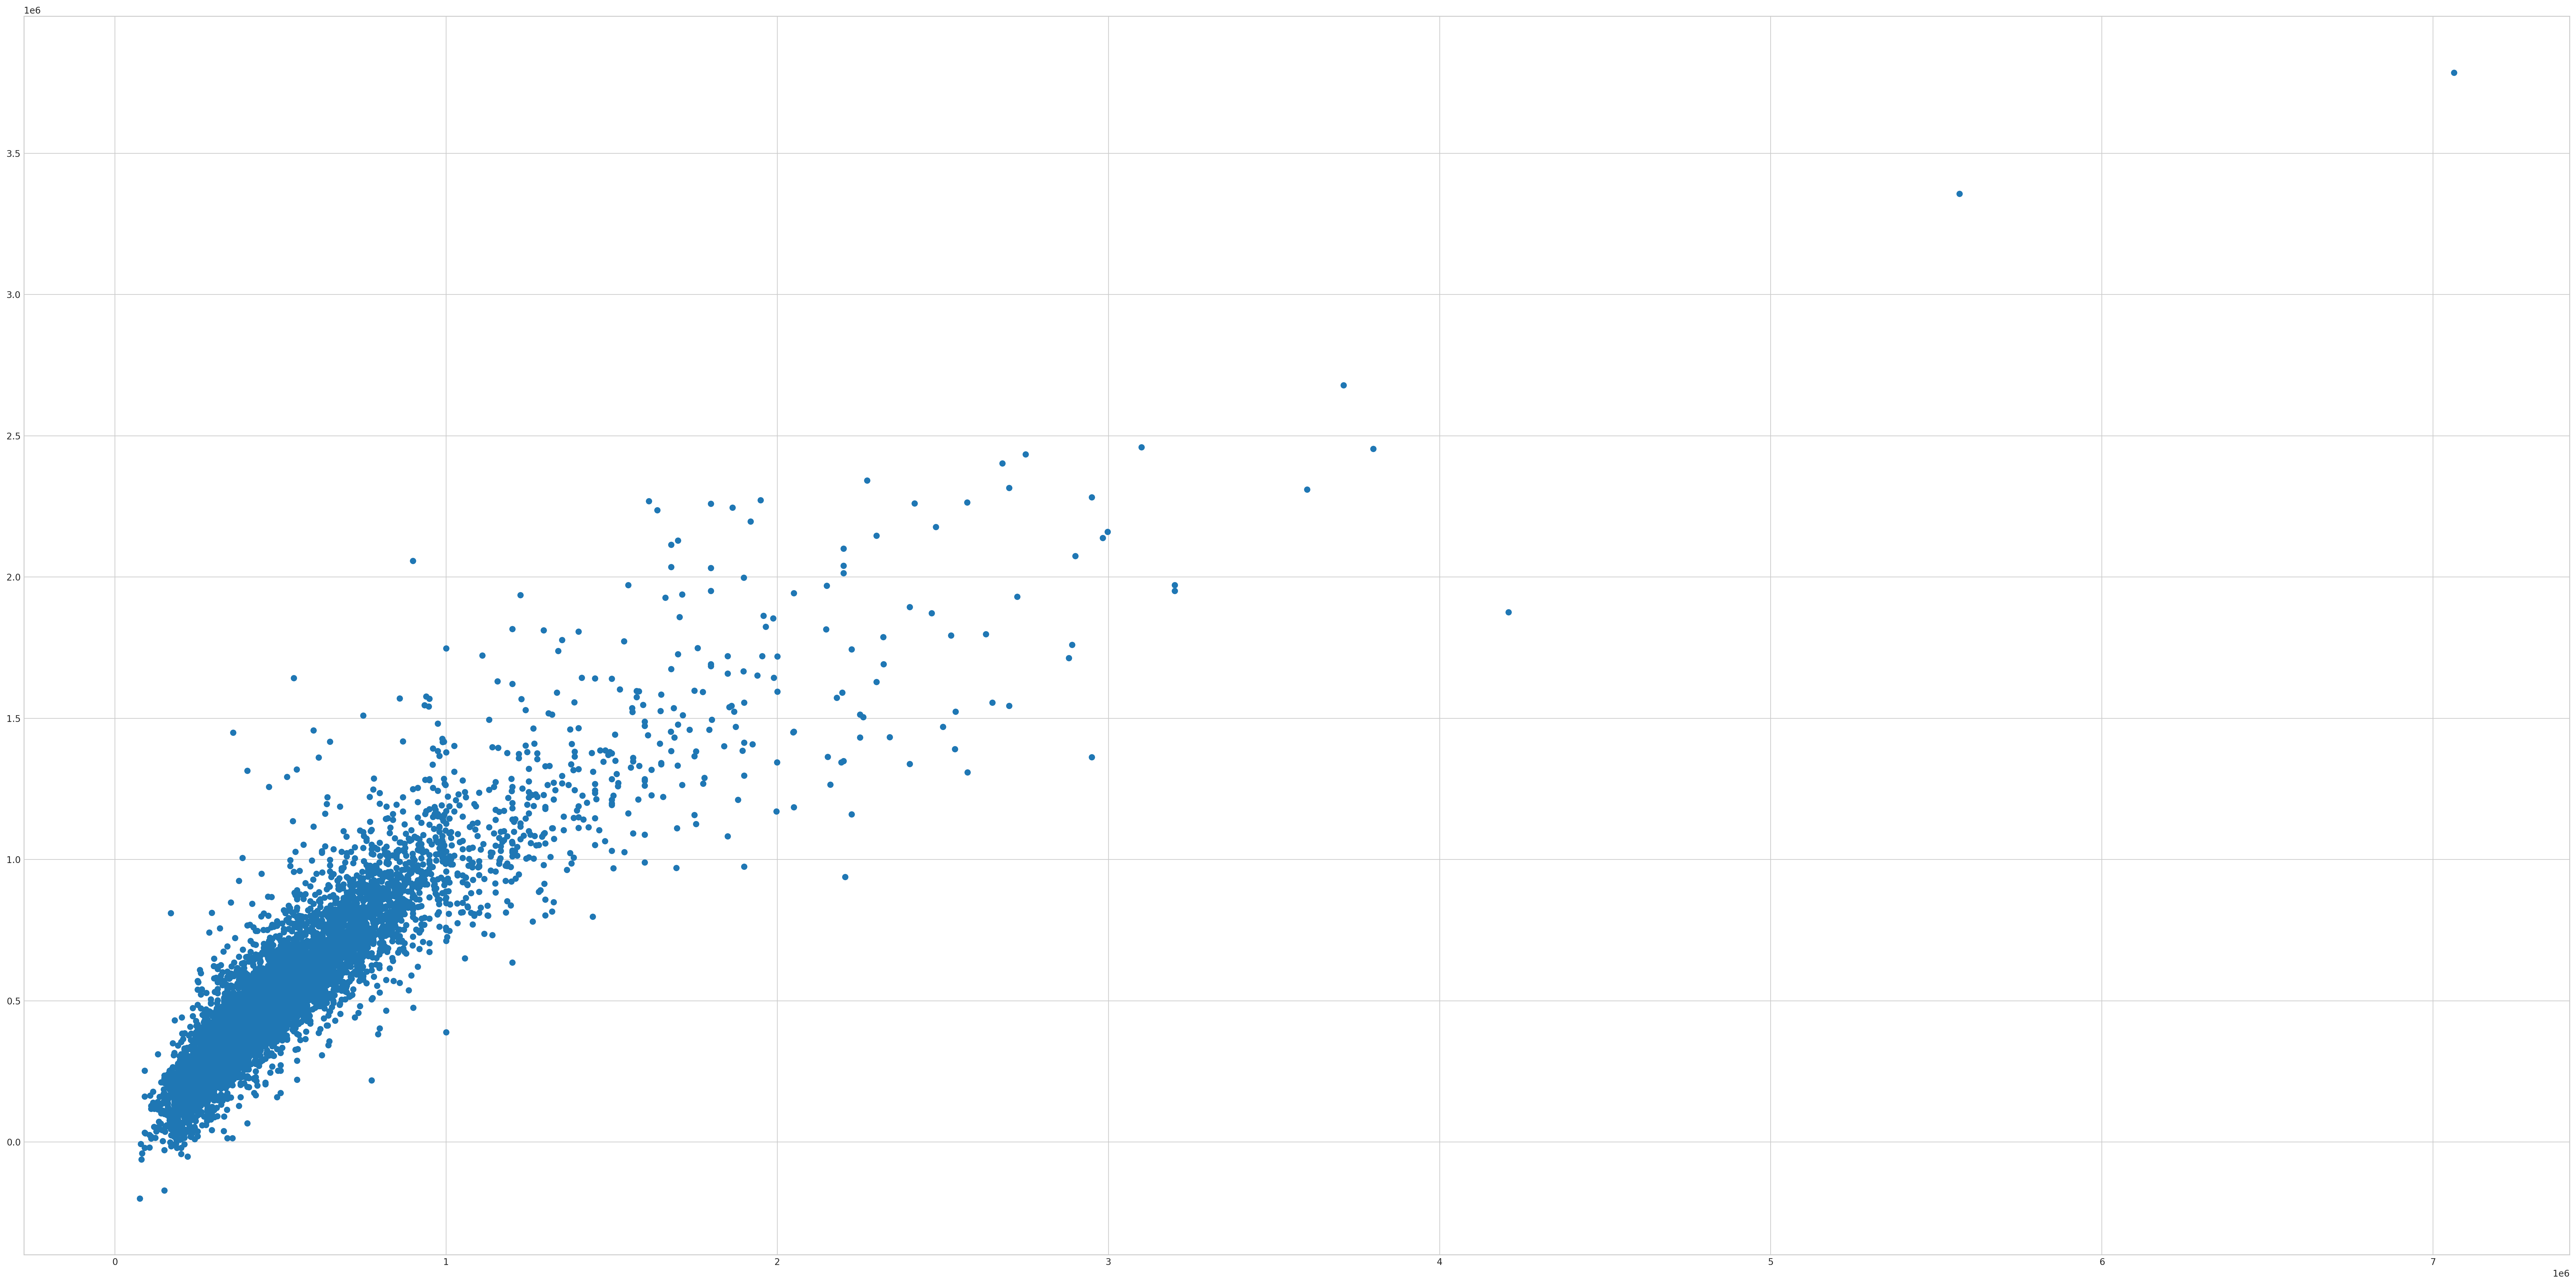

In [105]:
%matplotlib inline
plt.figure(figsize=(40,20))
plt.scatter(y_test,predictions)

In [106]:
dfr = pd.DataFrame({'y_test': y_test,'predictions': predictions})
dfr

,y_test,predictions
1,221900,1.664529e+05
3,180000,1.430203e+05
11,662500,8.229881e+05
18,485000,5.762722e+05
20,230000,1.426221e+05
...,...,...
21596,520000,5.147781e+05
21601,1537000,1.773104e+06
21605,429000,4.018962e+05
21606,610685,5.433961e+05


In [107]:
lr.score(X_train, y_train)

0.806439622281405

In [108]:
# Mean Squared Error
print(metrics.mean_squared_error(y_test, predictions))

27140059624.310627


In [109]:
R2_oos = 1 - np.mean((predictions - y_test)**2)/np.var(y_test)

In [110]:
R2_oos

0.7977665204038027

In [111]:
# Root Mean Squared Error
print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

164742.4038440335


In [112]:
alphas = np.arange(0.0001, 10, 0.1)

In [113]:
res = {}
for alpha in tqdm(alphas):
    
    ridge = Ridge(random_state=0, alpha=alpha)
    lasso = Lasso(random_state=0, alpha=alpha)
    
    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    
    pred_lasso = lasso.predict(X_val)*sigma_y_train + mu_y_train
    pred_ridge = ridge.predict(X_val)*sigma_y_train + mu_y_train
    
    R2_val_ridge = 1 - np.mean((pred_ridge - y_val)**2)/np.var(y_val)
    R2_val_lasso = 1 - np.mean((pred_lasso - y_val)**2)/np.var(y_val)
    
    rmse_val_ridge = np.sqrt(metrics.mean_squared_error(y_val, pred_ridge))
    rmse_val_lasso = np.sqrt(metrics.mean_squared_error(y_val, pred_lasso))
    
    res[alpha] = pd.concat({"Ridge":pd.Series({"R2":R2_val_ridge, "RMSE":rmse_val_ridge}), "Lasso":pd.Series({"R2":R2_val_lasso, "RMSE":rmse_val_lasso})})

  0%|          | 0/100 [00:00<?, ?it/s]/home/mathieusavvas_dimitriades/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.712e+01, tolerance: 9.077e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


In [130]:
pd.concat(res, axis = 1).stack().unstack(level = 1).R2.max()

0.8148569865087194

In [124]:
pd.concat(res, axis = 1).stack().unstack(level = 1).RMSE.min()

154557.53863498505

###  What metrics can we used for regression problems?

#### Mean Absolute Error (MAE) is the mean of the absolute value of the errors:

#### 1n∑i=1n|yi−y^i|
 
#### Mean Squared Error (MSE) is the mean of the squared errors:

#### 1n∑i=1n(yi−y^i)2
 
#### Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:

#### 1n∑i=1n(yi−y^i)2−−−−−−−−−−−−√

## XGBOOST,LightGBM

### Importing all the importing libraries which will be used for performing analysis using XGBOOST, LightGBM and OLS

In [60]:
# imports 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgbm
import gc
from sklearn.linear_model import LinearRegression
import random
import datetime as dt

### Parameters

In [61]:
XGB_WEIGHT = 0.6415
BASELINE_WEIGHT = 0.0056
OLS_WEIGHT = 0.0828

XGB1_WEIGHT = 0.8083  # Weight of first in combination of two XGB models

BASELINE_PRED = 0.0115   # Baseline based on mean of training data, per Oleg

## What is Light GBM?
 Light GBM is a gradient boosting framework that uses tree based learning algorithm.

## How it differs from other tree based algorithm?
 Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

## Below diagrams explain the implementation of LightGBM and other boosting algorithms

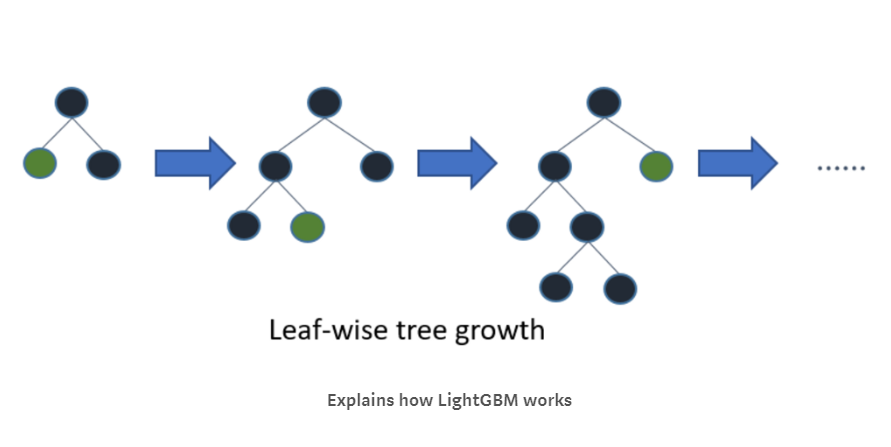

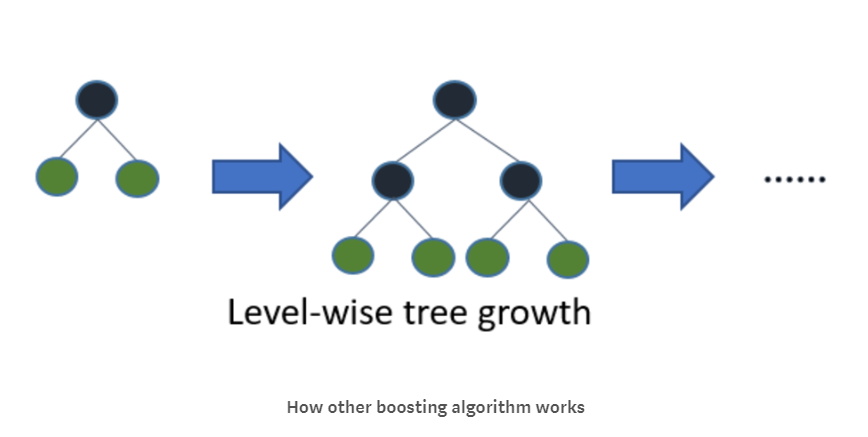

## What are its Advantages?

 LightGBM as we already know is a gradient boosting framework that makes the use of **tree-based learning algorithms**. It is designed with the following **advantages** in order to be distributed as well as efficient:

 **Higher efficiency as well as faster training speed**

 **Usage of lower memory**

 **Better accuracy**

 **Supports Parallel and GPU learning**

 **Data of large-scale can be handled**
 
## Can we use Light GBM everywhere?

No, it is **not advisable to use LGBM on small datasets**. Light GBM is **sensitive** to overfitting and can easily overfit small data. Their is no threshold on the number of rows but my experience suggests me to use it only for data with **10,000+ rows**. 

##### This was one of the main reasons why we planned to use LightGBM on our project data


## PROCESS DATA FOR LIGHTGBM

### Initializing Parameters

Description of the parameters of LightGBM :

##### RUN LIGHTGBM

In [66]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.345    
params['bagging_fraction'] = 0.85 # sub_row
# Note: To enable bagging, bagging_freq should be set to a non zero value as well
params['bagging_freq'] = 40 #after every 40 iterations bagging will be performed
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

## XGBoost ##

 **XGBoost** is an open-source software library which provides the gradient boosting framework for C++, Java, Python, R, and Julia. It works on Linux, Windows, and macOS.
 
 **XGBoost** is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or    tabular data.

 **XGBoost** is an implementation of gradient boosted decision trees designed for speed and performance.

# References :

https://media.readthedocs.org/pdf/lightgbm/latest/lightgbm.pdf

https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

https://www.statisticallysignificantconsulting.com/RegressionAnalysis.htm

https://www.techleer.com/articles/489-lightgbm-a-light-gradient-boosting-machine/

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html